<a href="https://colab.research.google.com/github/PsorTheDoctor/deep-neural-nets/blob/main/07_cnn_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks (CNN)

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
from PIL import Image

## Load CIFAR10 dataset for training, testing and validation

In [30]:
data = torchvision.datasets.CIFAR10('~/data', train=True, download=True)
mu = data.data.mean(axis=(0, 1, 2)) # (N, H, W, 3) -> 3
std = data.data.std(axis=(0, 1, 2)) # (N, H, W, 3) -> 3
print("Dataset size:", data.data.shape, "Mu:", mu, "Sigma:", std)

loader_kwargs = dict(batch_size=128, num_workers=2)
n_valid = 2000

tfms_norm = transforms.Compose([
    transforms.ToTensor(),
    # ToTensor already maps 0-255 to 0-1, so devide mu and std by 255 below
    transforms.Normalize(mu / 255, std / 255),
])

# Now lets keep part of the training data for validation

data_valid = torchvision.datasets.CIFAR10('~/data', train=True, transform=tfms_norm)
data_valid.data = data_valid.data[-n_valid:]
data_valid.targets = data_valid.targets[-n_valid:]
loader_valid = torch.utils.data.DataLoader(data_valid, **loader_kwargs)

# function for loading train data by passing desired transforms for data augmentation
def get_loader_train(augmentations):
    data_train = torchvision.datasets.CIFAR10(
        '~/data', train=True,
        transform=transforms.Compose([augmentations, tfms_norm])
    )
    data_train.data = data_train.data[:-n_valid]
    data_train.targets = data_train.targets[:-n_valid]
    return torch.utils.data.DataLoader(data_train, **loader_kwargs, shuffle=True)

# test data
data_test = torchvision.datasets.CIFAR10('~/data', train=False, transform=tfms_norm)
loader_test = torch.utils.data.DataLoader(data_test, **loader_kwargs)

Files already downloaded and verified
Dataset size: (50000, 32, 32, 3) Mu: [125.30691805 122.95039414 113.86538318] Sigma: [62.99321928 62.08870764 66.70489964]


## Complete the following function to build your CNN layer

In [7]:
from IPython.core.interactiveshell import ProvisionalWarning
class CNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,
                 use_batchnorm=True, pool=False):
        super(CNNLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size) if pool else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

## Complete the following function to build CNN model

In [26]:
# Tip: 4 CNN layers should be sufficient!, increase the no. of channels from 3 -> 32 -> 64 -> 512,
# Remember to flatten after convolution layers before its passed to linear layers
# Also activation layer for final layers
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            CNNLayer(3, 32),
            CNNLayer(32, 64),
            CNNLayer(64, 512),
            CNNLayer(512, 1000, pool=True),
            nn.Flatten(),
            nn.Linear(100000, 1000),
            nn.Dropout(0.25),
            nn.Linear(1000, 10)
        )

    def forward(self, x):
        x = self.model(x)
        return x

## Use the following helper functions for training the model

In [20]:
def one_epoch(model, data_loader, opt=None):
    device = next(model.parameters()).device
    train = False if opt is None else True
    model.train() if train else model.eval()
    losses, correct, total = [], 0, 0
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train):
            logits = model(x)
        loss = F.cross_entropy(logits, y)

        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()

        losses.append(loss.item())
        total += len(x)
        correct += (torch.argmax(logits, dim=1) == y).sum().item()
    return np.mean(losses), correct / total


def train(model, loader_train, loader_valid, lr=1e-3, max_epochs=30, weight_decay=0., patience=3):
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_valid_accuracy = 0
    best_valid_accuracy_epoch = 0

    t = tqdm(range(max_epochs))
    for epoch in t:
        train_loss, train_acc = one_epoch(model, loader_train, opt)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        valid_loss, valid_acc = one_epoch(model, loader_valid)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        t.set_description(f'train_acc: {train_acc:.2f}, valid_acc: {valid_acc:.2f}')

        if valid_acc > best_valid_accuracy:
            best_valid_accuracy = valid_acc
            best_valid_accuracy_epoch = epoch

        if epoch > best_valid_accuracy_epoch + patience:
            break
    t.set_description(f'best valid acc: {best_valid_accuracy:.2f}')

    return train_losses, train_accuracies, valid_losses, valid_accuracies


def plot_history(train_losses, train_accuracies, valid_losses, valid_accuracies):
    plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    p = plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.ylim(0, 2)
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    p = plt.plot(train_accuracies, label='train')
    plt.plot(valid_accuracies, label='valid')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

## Now train your model using different augmentations, pooling, batch normalization etc. Report your best accuracy on test data

Tip: You should get test accuracy of more than 80%

In [32]:
def augmentations():
    return transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip()
    ])

loader_train = get_loader_train(augmentations())

model = CNN().cuda()
train_loss, train_acc, val_loss, val_acc = train(
    model, loader_train, loader_valid, max_epochs=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

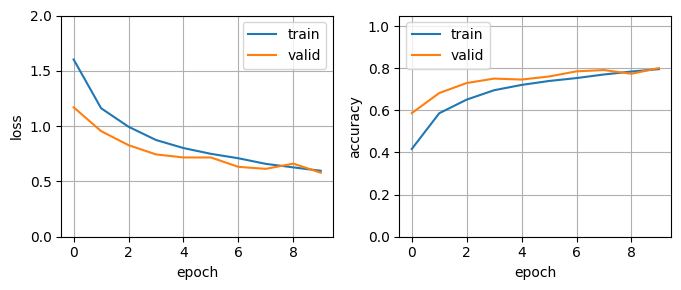

In [33]:
plot_history(train_loss, train_acc, val_loss, val_acc)

# Bonus

## Load resnet model

In [ ]:
model = torchvision.models.resnet18(pretrained=True).cuda()

# print the model architecture
print(model)

In [35]:
train_loss, train_acc, val_loss, val_acc = train(
    model, loader_train, loader_valid, max_epochs=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

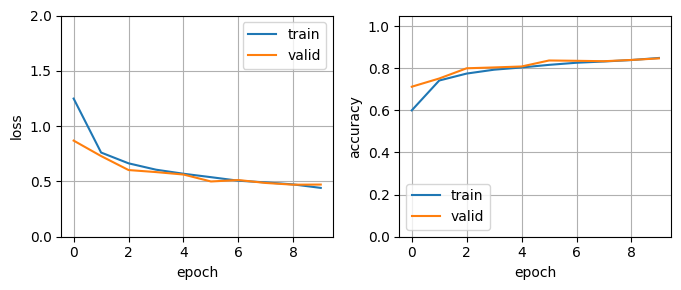

In [36]:
plot_history(train_loss, train_acc, val_loss, val_acc)